<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/vy-preprocessing/PIP_on_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install python-fastpip

  Created wheel for python-fastpip: filename=python_fastpip-1.2-cp36-none-any.whl size=3816 sha256=a8a65aa759439b4af6c8e40152b60b7155e1e3f30c8c64f5547500e047e22212
  Stored in directory: /root/.cache/pip/wheels/88/44/d3/0daeba86e0968e23e1ce93b5b8b7ef9b412b0ce1de027f7853
Successfully built python-fastpip


In [2]:
!pip install yellowbrick

In [3]:
try:
  from tslearn.clustering import TimeSeriesKMeans
except:
  !pip -q install tslearn
  from tslearn.clustering import TimeSeriesKMeans

     |████████████████████████████████| 778kB 5.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

     |████████████████████████████████| 624kB 5.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340341 sha256=4b895dfc9c78b8a8465711821ec94e8566176c1cb36a4979785df6bbb05e2ac4
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [5]:
!pip install kneed

In [6]:
#!git clone -l -s https://github.com/Amelrich/Capstone-Fall-2020.git capstone_git_repo

In [7]:
import numpy.random as rd

import pandas as pd
import numpy as np
import seaborn as sns
from fastpip import pip

import matplotlib.pyplot as plt
import os
%matplotlib inline
#os.chdir('/content/drive/My Drive/Capstone - JPM')
from yellowbrick.cluster import KElbowVisualizer
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import asarray
from numpy import save
from itertools import product
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
os.chdir('/content/drive/My Drive/Capstone - JPM/capstone_git_repo')
from TS_utils import TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians
from TS_utils import Synthetic_TS_generator
stg = Synthetic_TS_generator(noise=False)
X_synthetic = stg.get_array()

In [12]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

In [13]:
context_scale = 60
current_scale = 20
#gen = TS_generator(nb_timeseries=1000, chunk_size=context_scale)
#context_matrix = gen.get_array()
context_matrix = X_synthetic
#os.chdir('/content/drive/My Drive/Capstone - JPM')

In [14]:
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

# Scaler

- MinMaxScaler
- StandardScaler
- MedianScaler

In [15]:
def cluster_context_embed(context_pip, current, context, clustering_method):
    """clustering on the PIP Embedding of CONTEXT scale
    Inputs:
        context_pip (numpy array): PIP Embedding of Context matrix
        current (numpy array): true Current matrix
        context (numpy array): true Context matrix
        n_clusters (int): number of clusters
    Output: Data Visualizations, 1 row is 1 cluster
        1st figure in a row: the PIP Embedding of Context matrix and the cluster centroid
        2nd figure in a row: true Current time series and their mean
                                corresponding to the PIP Embedding in the cluster
        3rd figure in a row: true Context time series and their mean
                                corresponding to the PIP Embedding in the cluster
        4th figure in a row: example of 1 true Context time series belonging to that cluster 
    """
    model_context = clustering_method
    model_context.fit(context_pip)
    # Use global variable to retain value of y_train_pred_context after calling function
    global y_train_pred_context
    y_train_pred_context = model_context.predict(context_pip)
    ncols = 4
    nrows = len(np.unique(model_context.labels_))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    for cluster in range(len(np.unique(model_context.labels_))):
        indices = [i for i,x in enumerate(y_train_pred_context) if x == cluster]
        context_center = model_context.cluster_centers_[cluster]
        current_mean = np.mean(current[indices,:], axis=0)
        context_mean = np.mean(context[indices,:], axis=0)
        count = 0
        for i in range (len(indices)):
            axes[cluster,0].plot(context_pip[indices[i]],alpha=0.1, color='blue')
            axes[cluster,1].plot(current[indices,:][i,:], alpha = 0.1, color = 'blue')
            axes[cluster,2].plot(context[indices,:][i,:], alpha = 0.1, color = 'blue')
            count += 1
            
        axes[cluster,0].plot(context_center, color = 'red', linewidth = 3, alpha = 1)
        axes[cluster,0].title.set_text('CONTEXT EMBEDDING in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,0].grid();
        axes[cluster,0].set_xlabel("points");
        
        axes[cluster,1].plot(current_mean, color='orange', linewidth = 3, alpha = 1)
        axes[cluster,1].title.set_text('TRUE CURRENT scale in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,1].set_xlabel("days");
        axes[cluster,1].grid();
        
        axes[cluster,2].plot(context_mean, color='orange', linewidth = 3, alpha = 1)
        axes[cluster,2].title.set_text('TRUE CONTEXT scale in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,2].set_xlabel("days");
        axes[cluster,2].grid();
        
        axes[cluster,3].grid();
        axes[cluster,3].plot(context[indices,:][0,:])
        axes[cluster,3].title.set_text('TRUE ts in Cluster '+ str(cluster)+ ", n = " +str(count))
        axes[cluster,3].set_xlabel("days");

In [16]:
def clustering_pipeline(context_scale_matrix, clustering_method, pip_dim = 30):
  context_matrix_scale = context_scale_matrix.copy()
  current_matrix_scale = context_matrix_scale.copy()[:,context_scale - current_scale:]
  context_matrix_pip = reduce_dimension(context_matrix_scale.copy(), pip_dim)
  #context_matrix_smooth = DCT_lowpass_filter().fit_transform(context_matrix_pip.copy())
  cluster_context_embed(context_matrix_pip, current_matrix_scale, context_matrix_scale, clustering_method)
  
  plt.suptitle('Clustering using '+ " and " + str(clustering_method))

  """
  visualizer = SilhouetteVisualizer(clustering_method, colors='yellowbrick')
  visualizer.fit(context_matrix_pip)

  return visualizer.silhouette_score_
  """
  pass

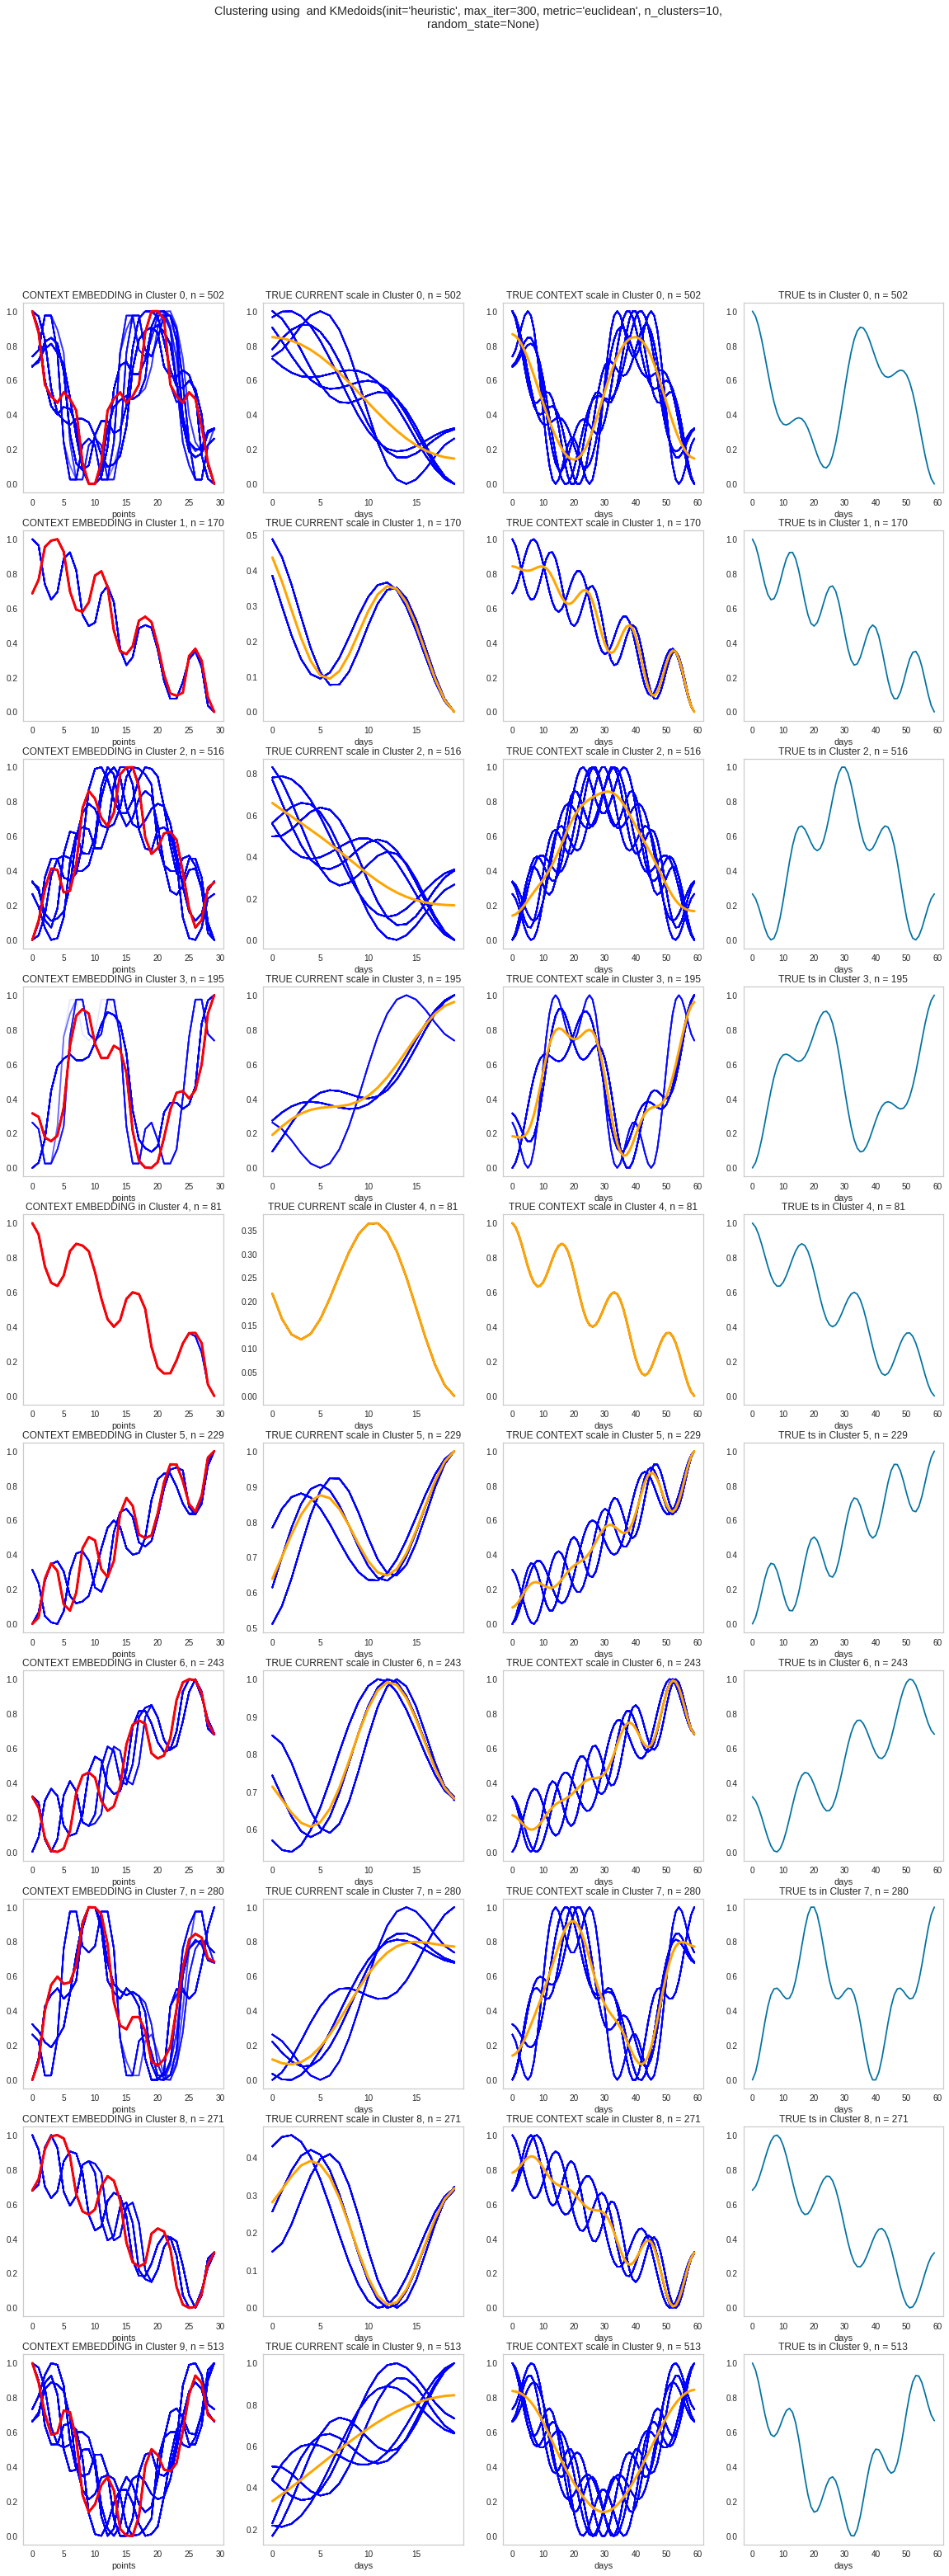

In [17]:
clustering_pipeline(context_matrix, KMedoids(n_clusters=10), pip_dim = 30)

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 3000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


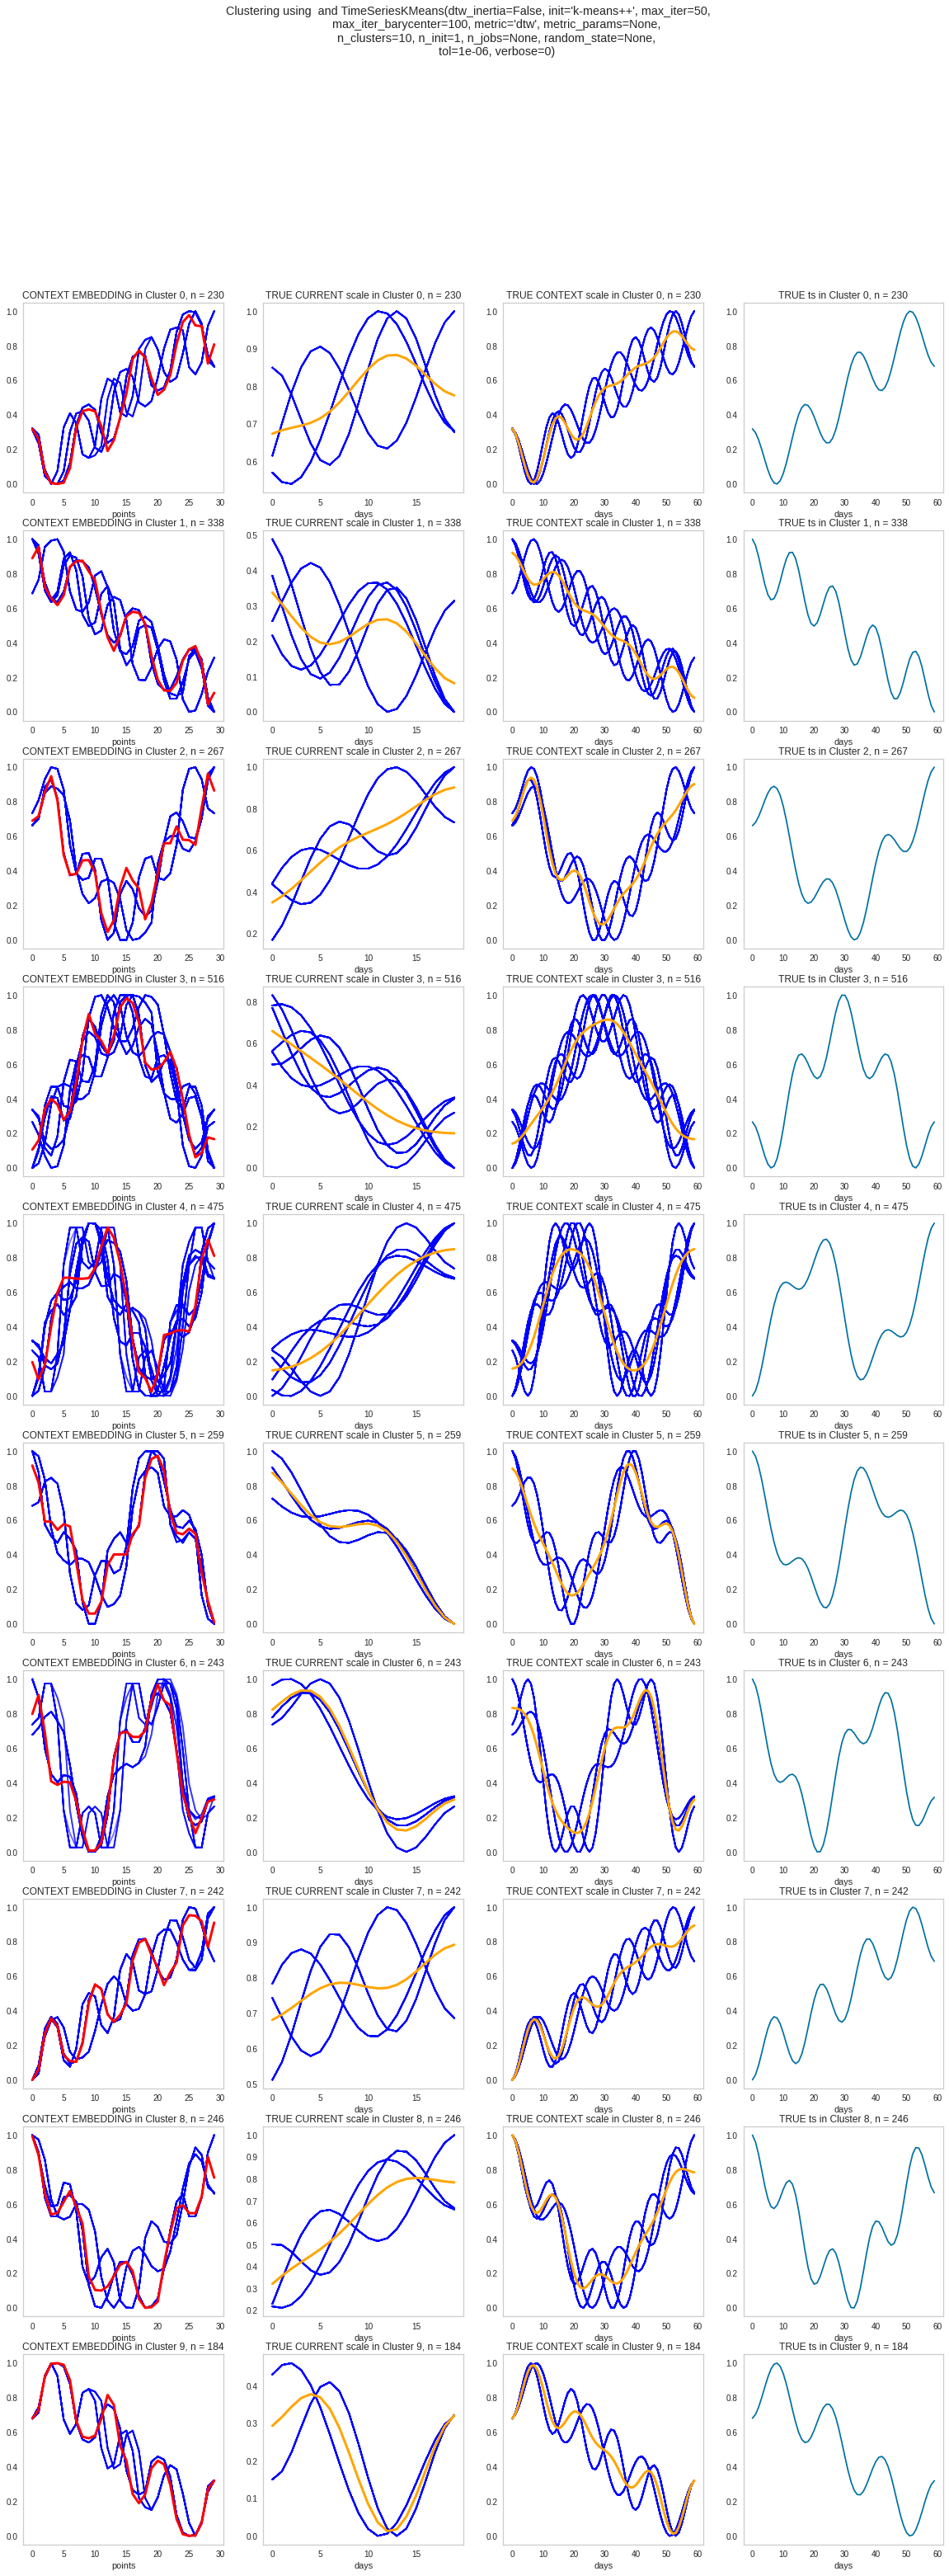

In [18]:
clustering_pipeline(context_matrix, TimeSeriesKMeans(n_clusters=10, metric = 'dtw'), pip_dim = 30)

# Entropy permutation

In [19]:
context_pip = reduce_dimension(context_matrix, 30)

In [20]:
current_matrix = context_matrix.copy()[:,context_scale - current_scale:]

In [23]:
def label_motif(window):
  """give consecutive 3 points a label
  window: can be a list or numpy 1d array
  return:
    label for each permutation
  """
  assert len(window) == 3, "please input an array or list of length 3"
  if window[0] <= window[1] and window[1] <= window[2]:
    return "motif_123"
  elif window[0]<= window[1] and window[2] <= window[1] and window[0] <= window[2]:
    return "motif_132"
  elif window[0]>= window[1] and window[2] >= window[0]:
    return "motif_213"
  elif window[0]<= window[1] and window[2] <= window[1] and window[0] >= window[2]:
    return "motif_231"
  elif window[0]>= window[1] and window[2] <= window[0]:
    return "motif_312"
  elif window[0] >= window[1] and window[1] >= window[2]:
    return "motif_321"

In [24]:
def count_motif(ts, plot = False):
  """
  count the frequency of every motif for each time series
  """
  motif_list = ["motif_123", "motif_132","motif_213", "motif_231", "motif_312", "motif_321"]
  motif_freq = dict.fromkeys(motif_list, 0)
  i=0
  while i<len(ts)-2:
    motif_freq[label_motif(ts[i:i+3])] += 1/(len(ts)-2)
    i += 1
  if plot:
    plt.bar(list(motif_freq.keys()), list(motif_freq.values()))
  return motif_freq

In [29]:
def get_motif(matrix):
  """count the motifs frequencies from the matrix
  """
  assert matrix.shape[1] == 3, "reduce dimension of matrix to 3 first"
  motif_list = ["motif_123", "motif_132","motif_213", "motif_231", "motif_312", "motif_321"]
  motif_freq = dict.fromkeys(motif_list, 0)
  for i in range(matrix.shape[0]):
    motif_freq[label_motif(matrix[i])] += 1
  return motif_freq

# KMeans with dtw

In [27]:
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters, metric = "dtw")
model.fit(context_pip)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=10, n_init=1, n_jobs=None, random_state=None,
                 tol=1e-06, verbose=0)

In [28]:
y_train_pred = model.predict(context_pip)

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 3000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


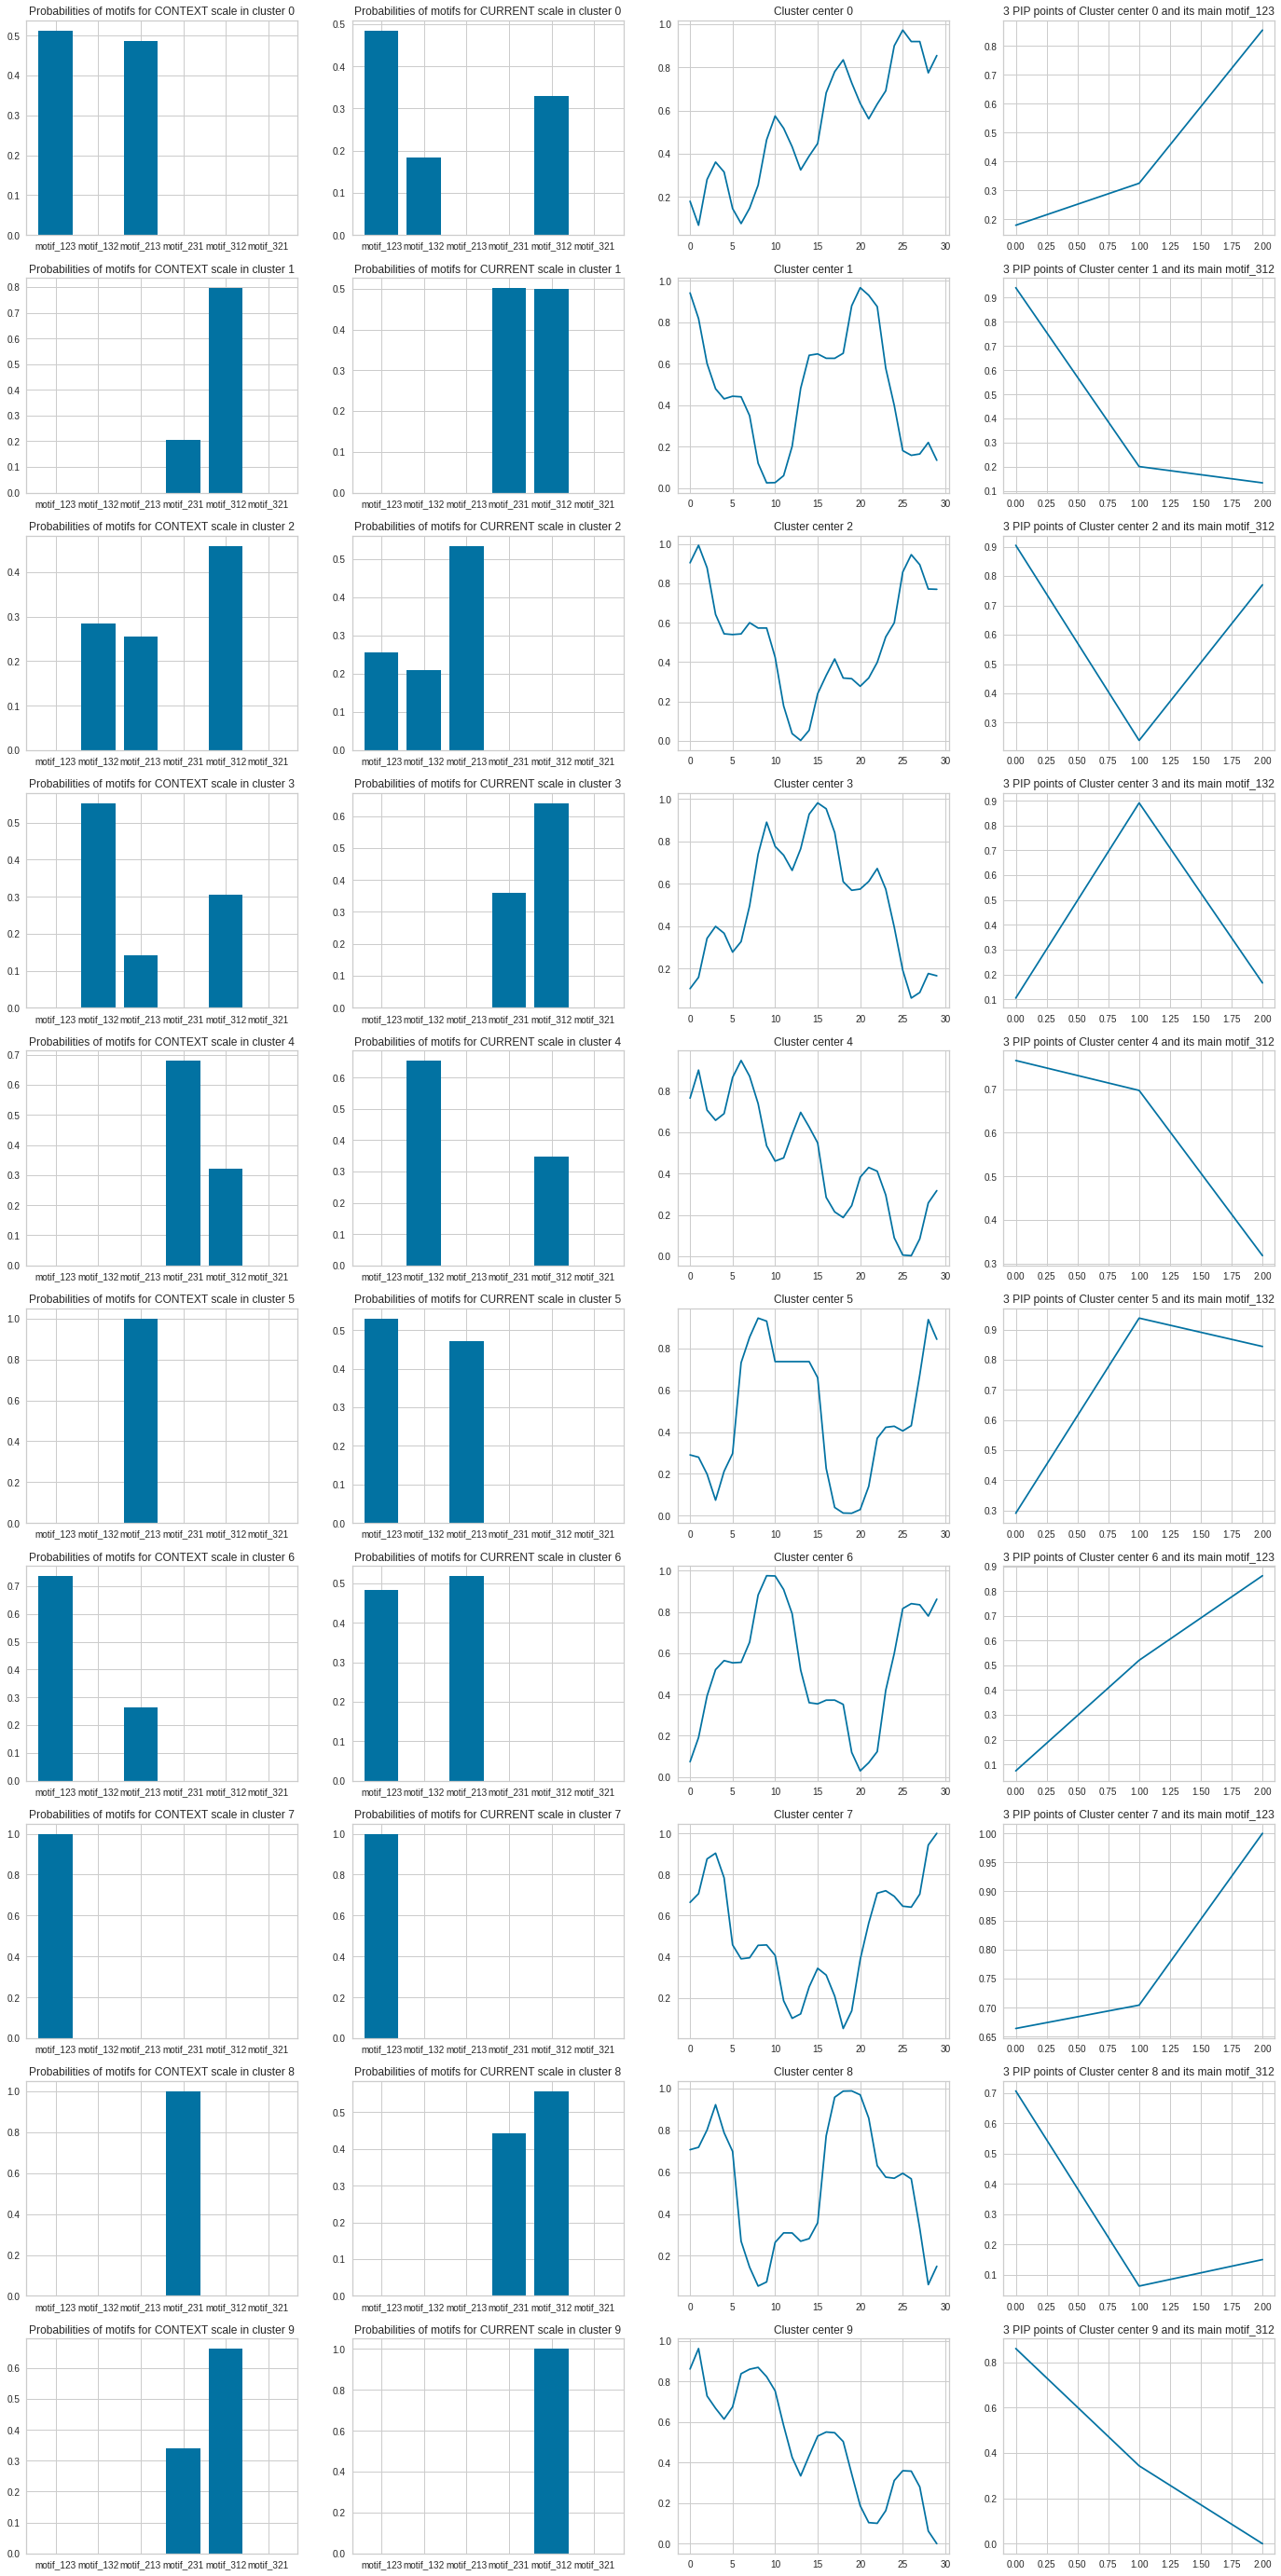

In [30]:
ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip = reduce_dimension(current_matrix[indices],3)
  context_motif_freq = {k: v/len(indices) for k, v in get_motif(cluster_context_pip).items()}
  current_motif_freq = {k: v/len(indices) for k, v in get_motif(cluster_current_pip).items()}
  ax[cluster,0].bar(list(context_motif_freq.keys()), list(context_motif_freq.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for CONTEXT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(current_motif_freq.keys()), list(current_motif_freq.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for CURRENT scale in cluster '+str(cluster))
  ax[cluster,2].plot(context_center)
  ax[cluster,2].title.set_text('Cluster center '+str(cluster))
  ax[cluster,3].plot(reduce_dimension(context_center.reshape(1,-1),3)[0])
  ax[cluster,3].title.set_text("3 PIP points of Cluster center "+str(cluster)+" and its main "+motif_cluster_center)
fig.savefig("motif_analysis.png")

## KMedoids

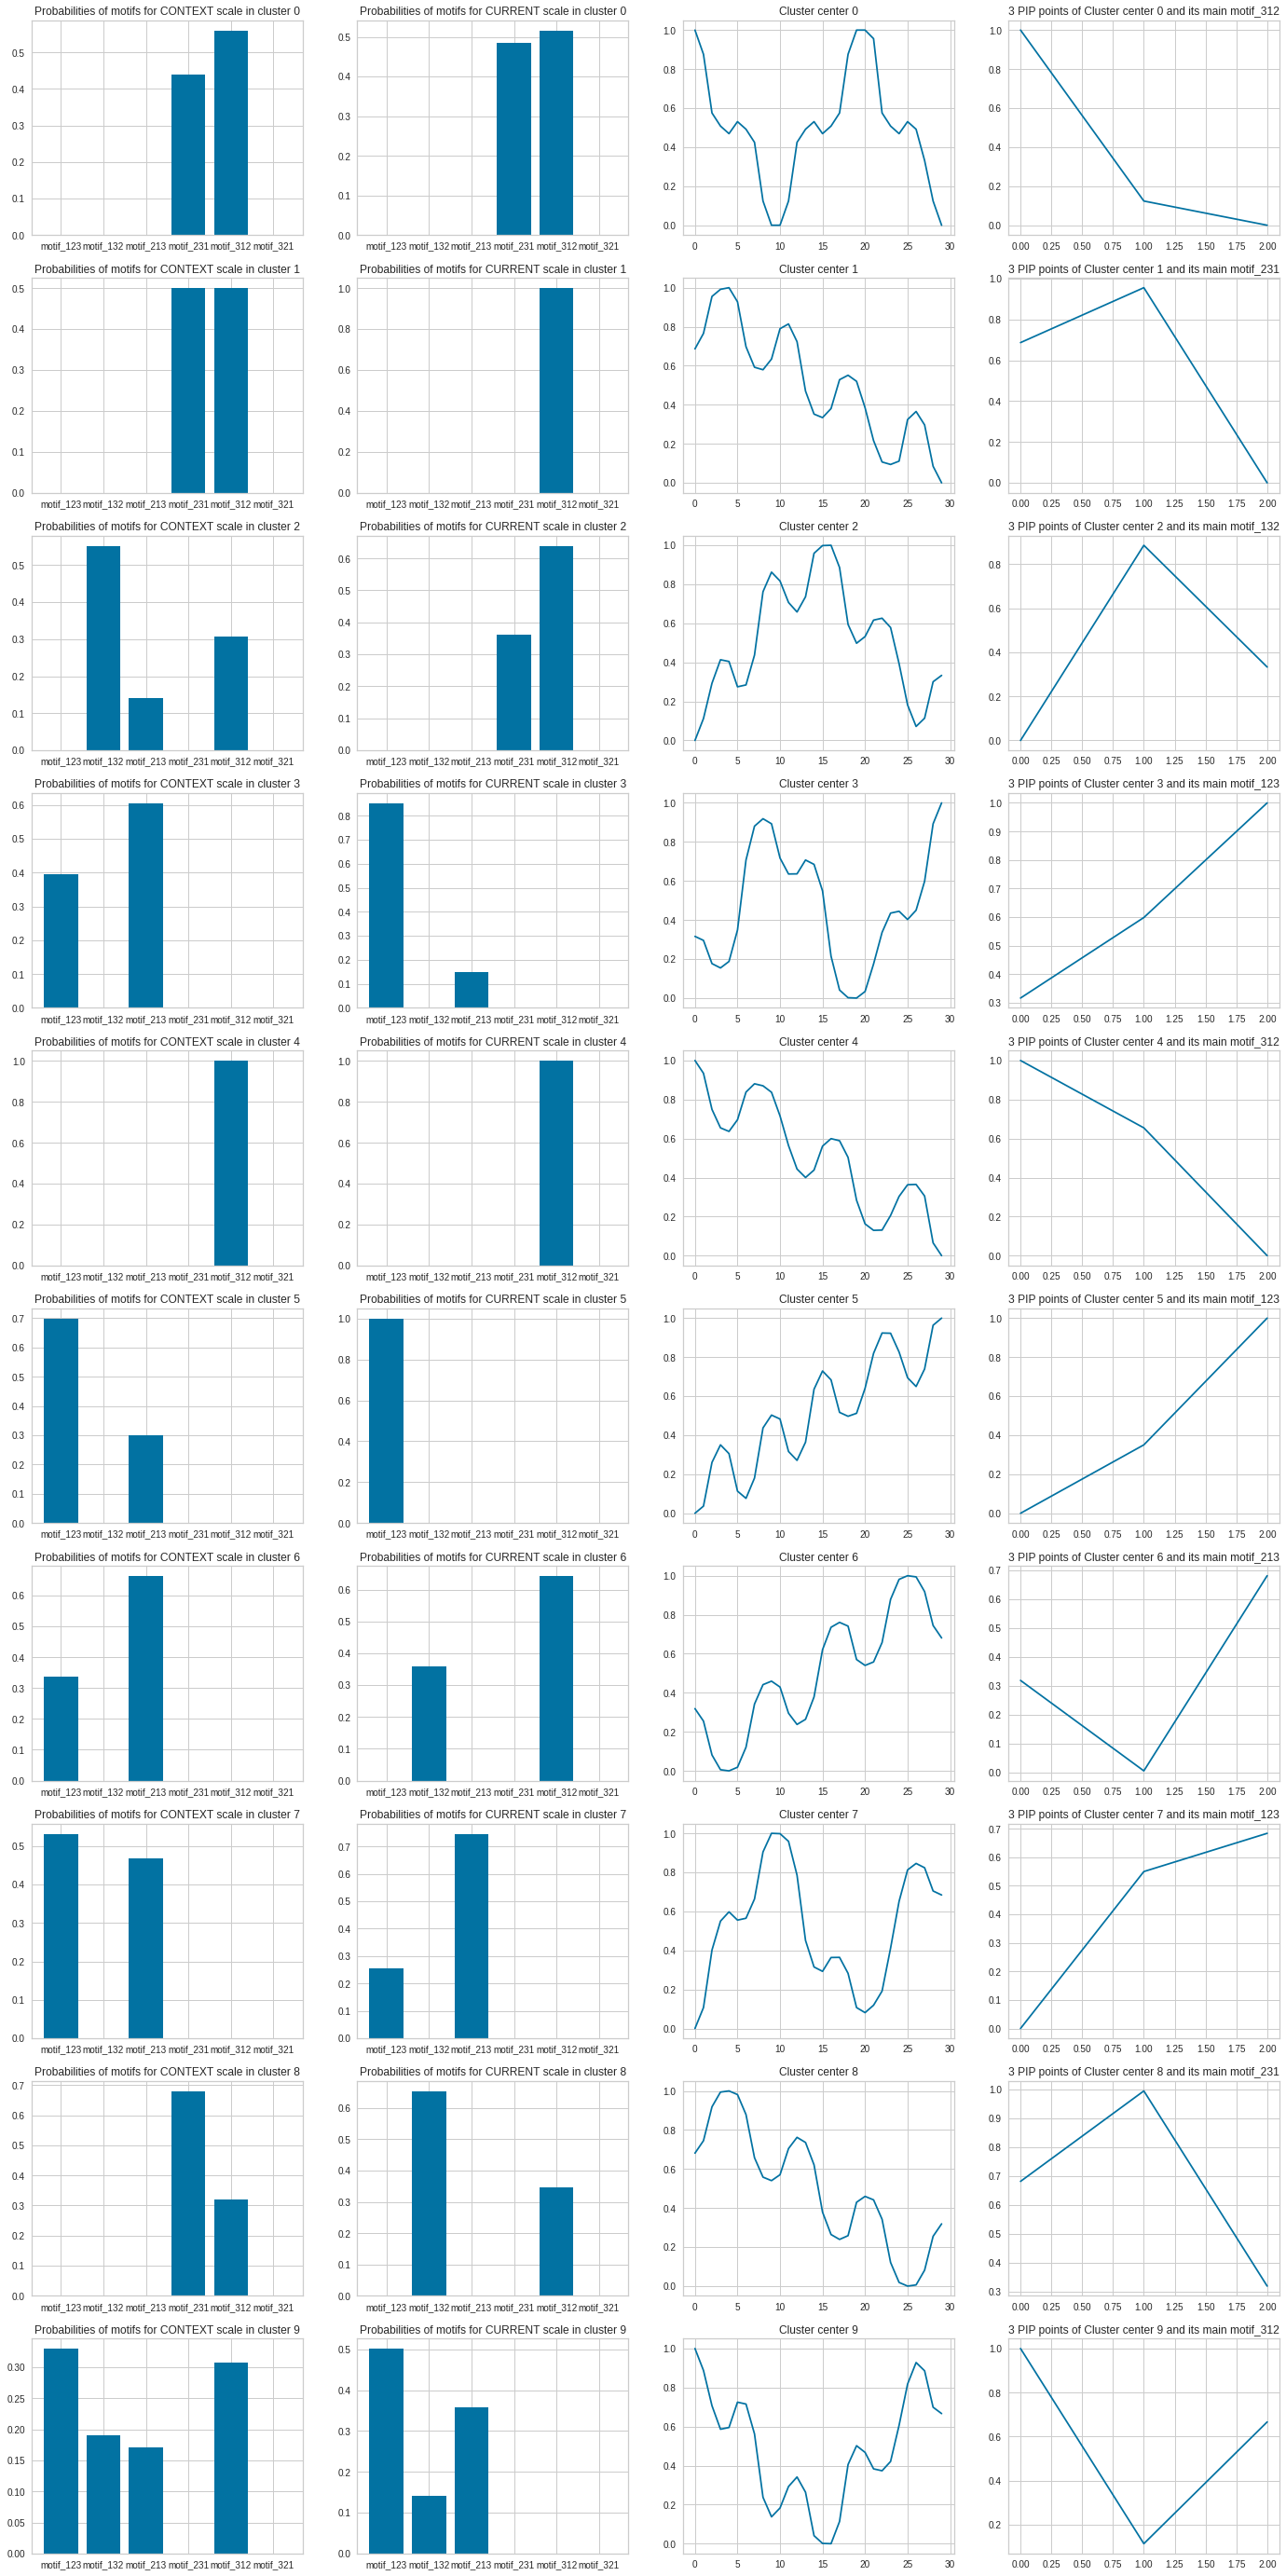

In [32]:
n_clusters = 10
model = KMedoids(n_clusters=n_clusters)
model.fit(context_pip)
y_train_pred = model.predict(context_pip)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  context_center = model.cluster_centers_[cluster]
  motif_cluster_center = label_motif(reduce_dimension(context_center.reshape(1,-1),3)[0])
  cluster_context_pip = reduce_dimension(context_matrix[indices],3)
  cluster_current_pip = reduce_dimension(current_matrix[indices],3)
  context_motif_freq = {k: v/len(indices) for k, v in get_motif(cluster_context_pip).items()}
  current_motif_freq = {k: v/len(indices) for k, v in get_motif(cluster_current_pip).items()}
  ax[cluster,0].bar(list(context_motif_freq.keys()), list(context_motif_freq.values()))
  ax[cluster,0].title.set_text('Probabilities of motifs for CONTEXT scale in cluster '+str(cluster))
  ax[cluster,1].bar(list(current_motif_freq.keys()), list(current_motif_freq.values()))
  ax[cluster,1].title.set_text('Probabilities of motifs for CURRENT scale in cluster '+str(cluster))
  ax[cluster,2].plot(context_center)
  ax[cluster,2].title.set_text('Cluster center '+str(cluster))
  ax[cluster,3].plot(reduce_dimension(context_center.reshape(1,-1),3)[0])
  ax[cluster,3].title.set_text("3 PIP points of Cluster center "+str(cluster)+" and its main "+motif_cluster_center)
fig.savefig("motif_analysis.png")